In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBRFClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

# Load the data
df = pd.read_csv('amazon_products_via_rainforest_api.csv')
df2 = pd.read_csv('amazon_products_via_rainforest_api2.csv')
# Display the first few rows of the dataframe
df = pd.concat([df,df2], axis=0)
#vectorizer = CountVectorizer(binary=True)

# Fit and transform the product names
#X = vectorizer.fit_transform(df['Product Name']).toarray()

# Create a DataFrame with the one-hot encoded features
#df_one_hot = pd.DataFrame(X, columns=vectorizer.get_feature_names_out(), index=df.index)

# Concatenate the original DataFrame with the new one-hot encoded DataFrame
#df = pd.concat([df, df_one_hot], axis=1)
df.fillna(0, inplace=True)
df = df.drop(['ASIN'],axis=1)
df['Unit Count'] = df['Unit Count'].replace(0, 1)  # Replace 0 units with 1 to avoid division by zero
df['true_price'] = df['Price'] / df['Unit Count']
df['Keyword'] = df['Keyword'].replace({'men': 0, 'women': 1, 'missing': -1})  # Assuming 'missing' as -1 or another category
df = df.drop(['Price','Product Name'], axis =1)
df = df.drop(['Category','Number of Reviews','Average Review Score'], axis=1)
# Display the updated DataFrame
print(df[['Unit Count', 'true_price', 'Keyword']].tail(50))

print(df.columns)

     Unit Count  true_price  Keyword
630         1.0        7.24        1
631         1.0        7.17        1
632         1.0       15.47        0
633         1.0       32.99        0
634         1.0       15.38        0
635         1.0        0.00        0
636         1.0       27.36        0
637         1.0       15.97        0
638         1.0       12.44        0
639         1.0        6.99        0
640         1.0        7.98        0
641         1.0       24.60        0
642         1.0       30.58        0
643         1.0       15.64        0
644         1.0       44.99        0
645         1.0       24.42        0
646         1.0        0.00        0
647         1.0       15.64        0
648         1.0       19.39        0
649         1.0       20.02        0
650         1.0       19.99        0
651         1.0        0.00        0
652         1.0        0.00        0
653         1.0        0.00        0
654         1.0        0.00        0
655         1.0       14.26        0
6

C:\Users\joshf\AppData\Local\Temp\ipykernel_35160\1686467520.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Keyword'] = df['Keyword'].replace({'men': 0, 'women': 1, 'missing': -1})  # Assuming 'missing' as -1 or another category


In [30]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

# Choose the number of clusters (k) and apply k-means clustering
k = 2  # Example number of clusters
kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_df)

# Add the cluster labels to your original DataFrame
df['Cluster'] = kmeans.labels_

print(df)


     Keyword  Manufacturer  Unit Count  true_price  Cluster
0          1           0.0         1.0        0.10        1
1          1           0.0         1.0        0.98        1
2          1           0.0         1.0        0.99        1
3          1           0.0         1.0        0.00        1
4          1           0.0         1.0        1.46        1
..       ...           ...         ...         ...      ...
675        0           0.0         1.0       19.99        0
676        0           0.0         1.0       19.99        0
677        0           0.0         1.0       19.79        0
678        0           0.0         1.0       15.97        0
679        0           0.0         1.0       18.78        0

[1368 rows x 5 columns]


In [31]:
import pandas as pd
from scipy.stats import f_oneway

# Assuming `df` is your DataFrame and 'Cluster' contains the cluster labels
features = df.columns.drop('Cluster')  # Adjust if there are other non-feature columns

# For storing ANOVA results
anova_results = {}

for feature in features:
    if df[feature].dtype == 'float64' or df[feature].dtype == 'int64':  # Adjust as necessary
        groups = [df[df['Cluster'] == cluster][feature] for cluster in df['Cluster'].unique()]
        F_statistic, p_value = f_oneway(*groups)
        anova_results[feature] = p_value

# Sort features by significance (lower p-value means more significant)
sorted_features = sorted(anova_results, key=anova_results.get)
if sorted_features:  # Ensure there are numeric features processed
    print("Numeric features most correlated with 'Cluster' (sorted by significance):")
    for feature in sorted_features[:10]:  # Adjust the number to display as needed
        print(f"{feature}: p-value = {anova_results[feature]:.4f}")

Numeric features most correlated with 'Cluster' (sorted by significance):
Keyword: p-value = 0.0000
Manufacturer: p-value = nan
Unit Count: p-value = nan
true_price: p-value = 0.0013


C:\Users\joshf\AppData\Local\Temp\ipykernel_35160\3977557979.py:13: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  F_statistic, p_value = f_oneway(*groups)


In [32]:
sorted_features

['Keyword', 'Manufacturer', 'Unit Count', 'true_price']

0.297409


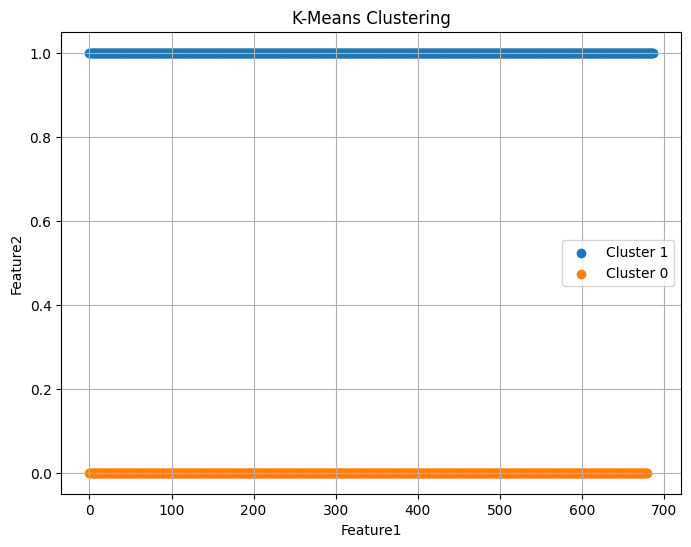

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
for cluster in df['Cluster'].unique():
    cluster_group = df[df['Cluster'] == cluster]
    plt.scatter(cluster_group['Keyword'], cluster_group['true_price'], label=f'Cluster {cluster}')
plt.title('K-Means Clustering')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.legend()
plt.grid(True)
plt.show()